## 1. Import Modules and Data
Accroding to original paper <a href="https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf">Improving Language Understanding by Generative Pre-Training</a>, GPT is pretrained on bookcorpus dataset, described by [Zhu and Kiros et al](https://yknzhu.wixsite.com/mbweb). You can learn more from [here](https://huggingface.co/datasets/bookcorpus/bookcorpus0) and download from [this branch](https://huggingface.co/datasets/bookcorpus/bookcorpus/tree/refs%2Fconvert%2Fparquet/plain_text/train).

The full BookCorpus dataset is too large, so we only use 10% of it for pre-training as examples. In `load_data`, all plain text will be tokenized and converted to token id with BPE algorithm. Finally, a data loader will be returned where each batch is token ids tensor with shape `[batch_size, max_len]`.

In [16]:
from data import load_data

dataloader = load_data("bookcorpus", loading_ratio=0.1, num_proc=5)

## 2. Build Model

I've pointed out key structure differences between GPT and vanilla transformer in [README](./README.md), but I still want to highlight that the GeLU used in feed forward layers in decoder block is approximate with `tanh`.

In [18]:
import torch

import config
from modules.gpt import GPT

device = torch.device("cuda:0")
model = GPT(
    vocab_size=config.vocab_size,
    max_len=config.max_len,
    d_model=config.d_model,
    n_head=config.n_head,
    n_layer=config.n_layer,
    dropout=config.dropout,
).to(device)

number of parameters: 116.14M


## 3. Train Model

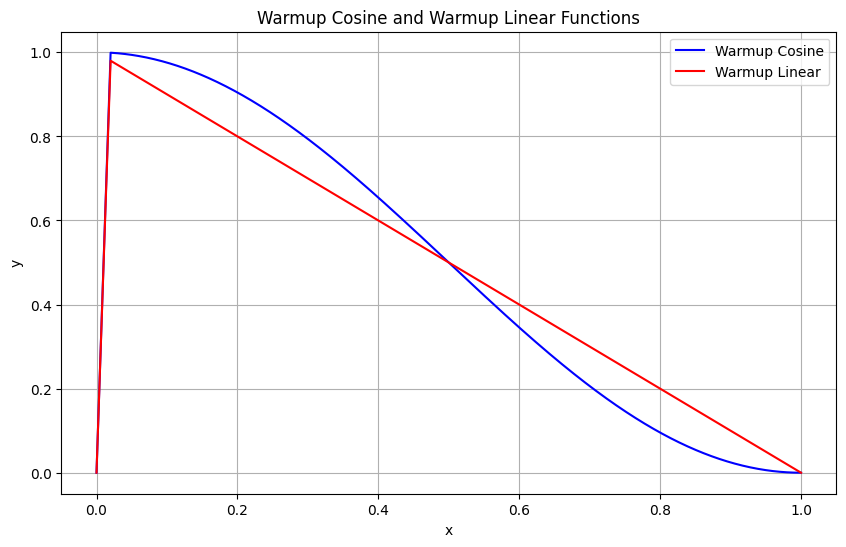

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 Warmup Cosine 函数
def warmup_cosine(x, warmup=0.002):
    s = (x <= warmup).astype(np.float32)
    return s * (x / warmup) + (1 - s) * (0.5 * (1 + np.cos(np.pi * x)))

# 定义 Warmup Linear 函数
def warmup_linear(x, warmup=0.002):
    s = (x <= warmup).astype(np.float32)
    return (s * (x / warmup) + (1 - s)) * (1 - x)

# 生成输入数据
x = np.linspace(0, 1, 1000)

# 计算每个函数的输出
y_cosine = warmup_cosine(x,0.02)
y_linear = warmup_linear(x,0.02)

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(x, y_cosine, label="Warmup Cosine", color="blue")
plt.plot(x, y_linear, label="Warmup Linear", color="red")

# 添加标题和标签
plt.title("Warmup Cosine and Warmup Linear Functions")
plt.xlabel("x")
plt.ylabel("y")

# 添加图例
plt.legend()

# 显示图像
plt.grid(True)
plt.show()
